<a href="https://colab.research.google.com/github/Hamza-Faarooq/MLE_Intern_Task/blob/main/MLE_Intern_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTING LIBRARIES**

In [1]:
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

# **IMPORTING THE SENTIMENT-140 DATASET**

In [2]:
from google.colab import drive
drive.mount("/content/drive")

# Specify the encoding as 'latin-1' to handle characters that are not valid in utf-8
# Added engine='python' to handle potential parsing issues with delimiters or quoting
# Explicitly setting sep and quotechar based on standard CSV format
data = pd.read_csv("/content/training.1600000.processed.noemoticon.csv",
                   encoding='latin-1',
                   engine='python',
                   sep=',',          # Explicitly set the separator to comma
                   quotechar='"' ,
                   on_bad_lines='skip'# Explicitly set the quote character to double quote
                  )

Mounted at /content/drive


# **DATA PRE PROCESSING**

### Renamed default column names to meaningful labels. Mapped sentiment labels from numeric (0, 2, 4) to textual categories (negative, neutral, positive) for easier interpretation.

In [25]:
data.columns = ['sentiment', 'tweet_id', 'date', 'query', 'user', 'text']
sentiment_map = {0: 'negative', 2: 'neutral', 4: 'positive'}
data['sentiment'] = data['sentiment'].map(sentiment_map)

# **CLEANING THE TWEETS**
### Cleaned each tweet by removing URLs, mentions, hashtags, non-alphabetic characters, and stopwords. Applied lemmatization using NLTK to normalize the words. This prepares the data for feature extraction.

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['clean_text'] = data['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# **EXPLORATORY DATA ANALYSIS (EDA)**
### Performed basic EDA to understand the class distribution of sentiments and analyze the length of cleaned tweets. Also identified the most common words for each sentiment category.

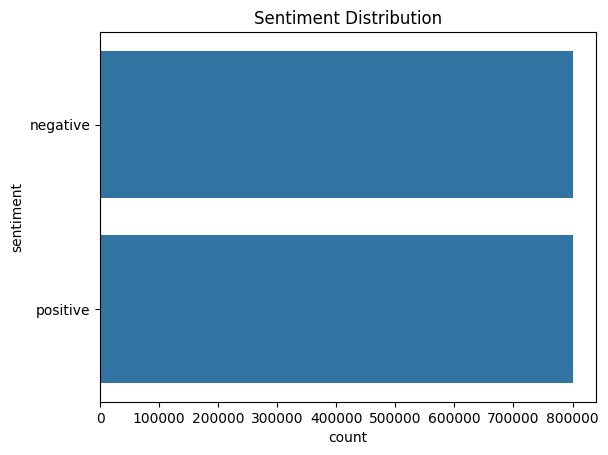

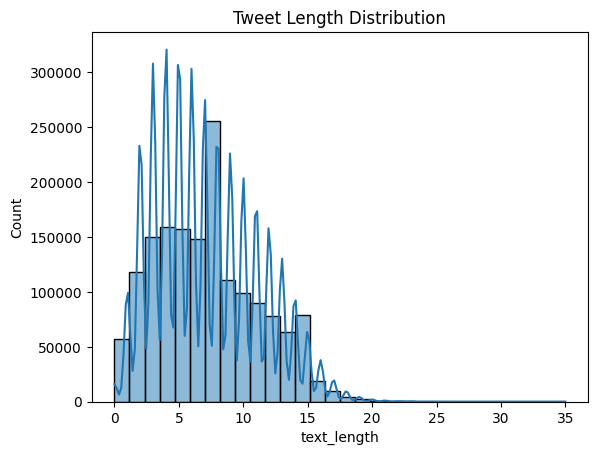

In [26]:
sns.countplot(data['sentiment'])
plt.title('Sentiment Distribution')
plt.show()

data['text_length'] = data['clean_text'].apply(lambda x: len(x.split()))
sns.histplot(data['text_length'], bins=30, kde=True)
plt.title('Tweet Length Distribution')
plt.show()

No common words in the neutral case, so removed the consequent part for the neutral ones.

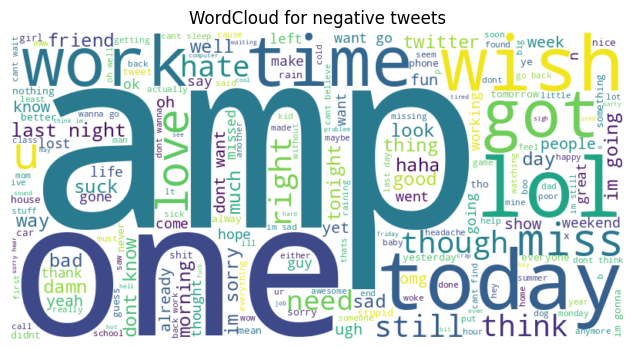

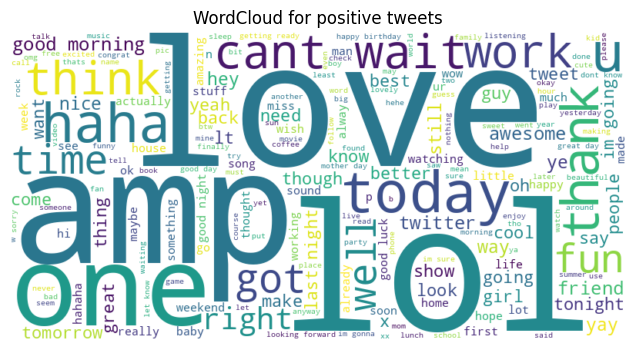

In [27]:
from wordcloud import WordCloud
for sentiment in ['negative', 'positive']:
    text = ' '.join(data[data['sentiment']==sentiment]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for {sentiment} tweets")
    plt.show()

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
X_ngrams = vectorizer.fit_transform(data['clean_text'])
top_ngrams = zip(vectorizer.get_feature_names_out(), X_ngrams.sum(axis=0).tolist()[0])
top_ngrams = sorted(top_ngrams, key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Bigrams:", top_ngrams)

Top 10 Bigrams: [('im going', 10824), ('good morning', 9833), ('dont know', 8889), ('feel like', 8380), ('look like', 6994), ('im gonna', 6471), ('im sorry', 6285), ('dont want', 6061), ('looking forward', 5558), ('good luck', 4943)]


# **TRAINING AND TESTING PART OF THE NOTEBOOK**
We are going to test different models on our dataset. There are multiple models avalaible and we are going to test it on Logistic Regression, Multinomial Naive Bayes, Random Forest Classifier, a Deep Neural Network an a pre-trained BERT model.

In [5]:
for sentiment in ['negative', 'neutral', 'positive']:
    words = ' '.join(data[data['sentiment']==sentiment]['clean_text']).split()
    common_words = Counter(words).most_common(10)
    print(f"Most common words in {sentiment} tweets:", common_words)

X = data['clean_text']
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Most common words in negative tweets: [('im', 103129), ('day', 50061), ('get', 47840), ('go', 47635), ('work', 45572), ('dont', 45158), ('cant', 43773), ('like', 41150), ('today', 36899), ('want', 34033)]
Most common words in neutral tweets: []
Most common words in positive tweets: [('im', 75272), ('good', 60938), ('day', 53973), ('love', 49509), ('u', 38199), ('get', 38094), ('like', 37947), ('thanks', 33823), ('lol', 33511), ('time', 33198)]


### Used TfidfVectorizer to convert cleaned text into numeric feature vectors. Limited to the top 5000 features to reduce dimensionality while retaining meaningful context.

In [6]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Trained two classical machine learning models: Logistic Regression and Multinomial Naive Bayes. These serve as strong baselines for text classification.

# **Logistic Regression**

In [7]:
lr = LogisticRegression(max_iter=200)
lr.fit(X_train_vec, y_train)

LogisticRegression(max_iter=200)

# **Multinomial Naive Bayes**

In [8]:
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)

MultinomialNB()

# **Random Forest Classifier**

#### Trained a Random Forest model using lightweight settings to handle the large dataset quickly. Optimizations include shallow trees and fewer estimators to trade off minimal accuracy for faster computation. While runnning without any sped-up computation, the model was taking an abruptly large amount of time, even over an hour. Time is a necessary component of our work so had to deploy this.

In [9]:
# We only need to calculate the predictions for the fast Random Forest here if it hasn't been done yet.
# Check if the fast Random Forest model has been trained and make predictions if needed.
try:
    rf_fast_pred  # Check if rf_fast_pred exists (meaning the fast RF was trained)
except NameError:
    print("Fast Random Forest model not trained. Training now...")
    from sklearn.ensemble import RandomForestClassifier
    import time

    # For very large datasets - prioritize speed over slight accuracy loss
    rf_fast = RandomForestClassifier(
        n_estimators=25,           # Very few trees
        max_depth=8,               # Shallow trees
        min_samples_split=50,      # Large minimum split
        min_samples_leaf=25,       # Large minimum leaf
        max_features='log2',       # Even fewer features per split
        max_samples=0.6,           # Use only 60% of data per tree
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    start_time = time.time()
    rf_fast.fit(X_train_vec, y_train)
    fast_time = time.time() - start_time

    rf_fast_pred = rf_fast.predict(X_test_vec)
    print(f"Ultra-fast training time: {fast_time:.2f} seconds ({fast_time/60:.2f} minutes)")
    from sklearn.metrics import accuracy_score
    print("Fast RF Accuracy:", accuracy_score(y_test, rf_fast_pred))

Fast Random Forest model not trained. Training now...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    5.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.3s finished


Ultra-fast training time: 7.06 seconds (0.12 minutes)
Fast RF Accuracy: 0.64093125


# **A DEEP NEURAL NETWORK AT WORK**



### 🔧 Deep Neural Network (DNN) – Memory Optimized Training

In this section, we build and train a Deep Neural Network (DNN) to classify tweet sentiment as **positive**, **neutral**, or **negative**.

⚙️ To handle the **large Sentiment140 dataset (1.6M tweets)** without running into memory issues, the code uses:
- A **custom batch-wise generator** to convert sparse vectors to dense arrays on-the-fly
- The `tf.data.Dataset` API for efficient input pipelining
- Dropout layers for regularization
- GPU memory growth configuration
- Early stopping and model checkpointing for best performance

🧠 The model architecture is simple but effective:
- Dense → Dropout → Dense → Dropout → Output

🏁 After training, we evaluate the model on test data using:
- Accuracy score
- Classification report (precision, recall, F1-score)

This version runs significantly faster and safer on large datasets than naive implementations.


In [13]:
print("=== DEEP NEURAL NETWORK - MEMORY OPTIMIZED ===")

# Enable memory growth for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Clear session and garbage once before training
K.clear_session()
gc.collect()

# Label encoding and one-hot
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)

# 🔁 Batch-wise generator to avoid .toarray() calls in loop
def sparse_batch_generator(X_sparse, y, batch_size=64, shuffle=True):
    indices = np.arange(X_sparse.shape[0])
    if shuffle:
        np.random.shuffle(indices)
    for start in range(0, len(indices), batch_size):
        end = min(start + batch_size, len(indices))
        batch_idx = indices[start:end]
        X_batch = np.array([X_sparse[i].toarray().flatten() for i in batch_idx], dtype=np.float32)
        y_batch = y[batch_idx].astype(np.float32)
        yield X_batch, y_batch

# ✅ Memory-efficient tf.data.Dataset
def get_tf_dataset(X_sparse, y, batch_size=64, shuffle=True):
    output_signature = (
        tf.TensorSpec(shape=(None, X_sparse.shape[1]), dtype=tf.float32),
        tf.TensorSpec(shape=(None, y.shape[1]), dtype=tf.float32)
    )
    dataset = tf.data.Dataset.from_generator(
        lambda: sparse_batch_generator(X_sparse, y, batch_size, shuffle),
        output_signature=output_signature
    )
    return dataset.prefetch(tf.data.AUTOTUNE)

# Set batch size
BATCH_SIZE = 64

# Prepare datasets
train_size = int(len(y_train_cat) * 0.8)
train_dataset = get_tf_dataset(X_train_vec[:train_size], y_train_cat[:train_size], BATCH_SIZE, shuffle=True)
val_dataset = get_tf_dataset(X_train_vec[train_size:], y_train_cat[train_size:], BATCH_SIZE, shuffle=False)
test_dataset = get_tf_dataset(X_test_vec, y_test_cat, BATCH_SIZE, shuffle=False)

# ✅ Build compact DNN model
dnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_vec.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')  # No float16
])

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
dnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print("Model compiled successfully")
print(f"Model parameters: {dnn_model.count_params():,}")

# Callbacks
checkpoint = ModelCheckpoint('dnn_model_best.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1)

# ✅ Train
try:
    history = dnn_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=5,
        callbacks=[checkpoint, early_stop],
        verbose=1
    )
    print("Training completed successfully!")

    # Load best weights
    dnn_model.load_weights('dnn_model_best.h5')

    # Predict in batches (no session clearing inside)
    print("Making predictions...")
    predictions_list = []
    for x_batch, _ in test_dataset:
        batch_pred = dnn_model.predict(x_batch, verbose=0)
        predictions_list.append(batch_pred)

    dnn_pred_proba = np.vstack(predictions_list)
    dnn_pred_encoded = np.argmax(dnn_pred_proba, axis=1)
    dnn_pred = label_encoder.inverse_transform(dnn_pred_encoded)

    # Evaluation
    from sklearn.metrics import accuracy_score, classification_report
    print("Accuracy:", accuracy_score(y_test, dnn_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, dnn_pred))

except Exception as e:
    print(f"Training failed: {e}")
    print("Try reducing BATCH_SIZE further or simplifying the model.")

finally:
    K.clear_session()
    gc.collect()
    print("Memory cleanup completed")

=== DEEP NEURAL NETWORK - MEMORY OPTIMIZED ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model compiled successfully
Model parameters: 648,514
Epoch 1/5
  15998/Unknown 298s 19ms/step - accuracy: 0.7572 - loss: 0.4961

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.77828, saving model to dnn_model_best.h5


16000/16000 ━━━━━━━━━━━━━━━━━━━━ 340s 21ms/step - accuracy: 0.7572 - loss: 0.4961 - val_accuracy: 0.7783 - val_loss: 0.4636
Epoch 2/5
15996/16000 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7873 - loss: 0.4538
Epoch 2: val_accuracy improved from 0.77828 to 0.78271, saving model to dnn_model_best.h5


16000/16000 ━━━━━━━━━━━━━━━━━━━━ 340s 21ms/step - accuracy: 0.7873 - loss: 0.4538 - val_accuracy: 0.7827 - val_loss: 0.4580
Epoch 3/5
15997/16000 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7998 - loss: 0.4353
Epoch 3: val_accuracy improved from 0.78271 to 0.78411, saving model to dnn_model_best.h5


16000/16000 ━━━━━━━━━━━━━━━━━━━━ 341s 21ms/step - accuracy: 0.7998 - loss: 0.4353 - val_accuracy: 0.7841 - val_loss: 0.4576
Epoch 4/5
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8081 - loss: 0.4231
Epoch 4: val_accuracy did not improve from 0.78411
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 382s 24ms/step - accuracy: 0.8081 - loss: 0.4231 - val_accuracy: 0.7839 - val_loss: 0.4604
Epoch 5/5
15997/16000 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8150 - loss: 0.4124
Epoch 5: val_accuracy did not improve from 0.78411
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 342s 21ms/step - accuracy: 0.8150 - loss: 0.4124 - val_accuracy: 0.7833 - val_loss: 0.4611
Restoring model weights from the end of the best epoch: 3.
Training completed successfully!
Making predictions...
Accuracy: 0.7856125

Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.77      0.78    159494
    positive       0.78      0.80      0.79    160506

    accuracy            

# **PREDICTION and COMPARING ALL THE MODELS**

In [14]:
# Step 1: Existing predictions
y_pred_lr = lr.predict(X_test_vec)
y_pred_nb = nb.predict(X_test_vec)
y_pred_rf = rf_fast_pred  # Already predicted earlier


# Step 2
# Efficient batch-wise DNN prediction
def sparse_batch_generator(X_sparse, batch_size=64):
    for start in range(0, X_sparse.shape[0], batch_size):
        end = min(start + batch_size, X_sparse.shape[0])
        batch = np.array([X_sparse[i].toarray().flatten() for i in range(start, end)], dtype=np.float32)
        yield batch

dnn_pred_batches = []
for x_batch in sparse_batch_generator(X_test_vec, batch_size=64):
    batch_output = dnn_model.predict(x_batch, verbose=0)
    dnn_pred_batches.append(batch_output)

dnn_output = np.vstack(dnn_pred_batches)
dnn_pred = label_encoder.inverse_transform(np.argmax(dnn_output, axis=1))


# Step 3: BERT predictions (already predicted earlier)
# bert_pred_labels = label_encoder_bert.inverse_transform(bert_preds.numpy())

# Step 3: Evaluation
models = ['Logistic Regression', 'Fast Random Forest', 'Naive Bayes', 'Deep Neural Network']
predictions = [y_pred_lr, y_pred_rf, y_pred_nb, dnn_pred]

accuracies = []

print("\n=== MODEL ACCURACY COMPARISON ===")
for i, pred in enumerate(predictions):
    acc = accuracy_score(y_test, pred)
    accuracies.append(acc)
    print(f"{models[i]} Accuracy: {acc:.4f}")


=== MODEL ACCURACY COMPARISON ===
Logistic Regression Accuracy: 0.7747
Fast Random Forest Accuracy: 0.6409
Naive Bayes Accuracy: 0.7577
Deep Neural Network Accuracy: 0.7856


## **A PLOT COMPARING ALL THE MODELS USED**

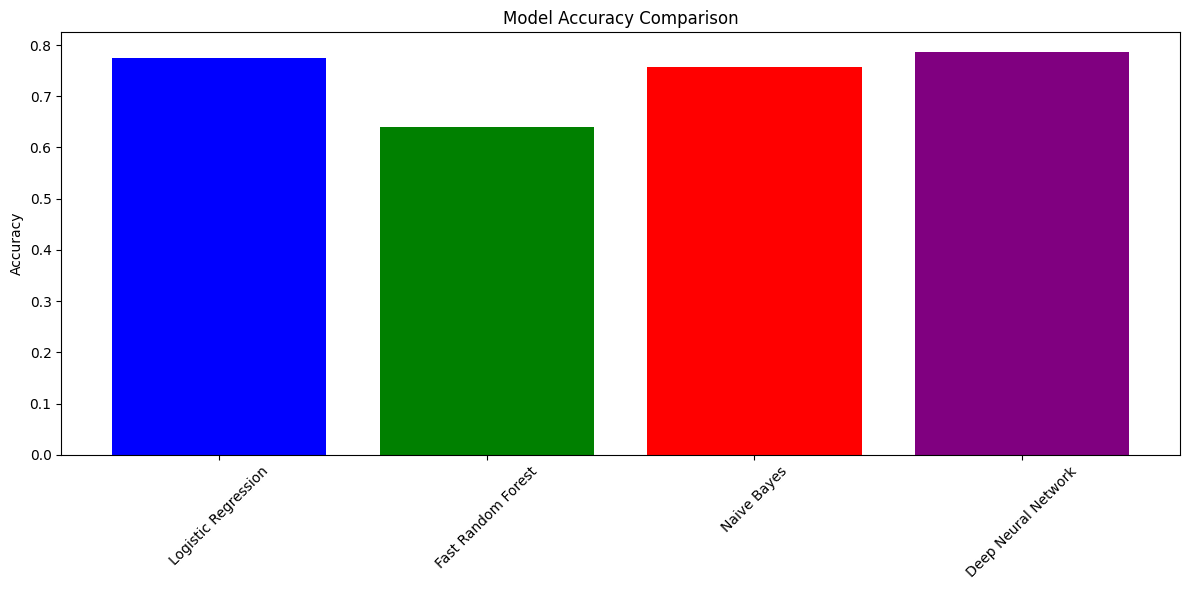

In [15]:
plt.figure(figsize=(12, 6))
colors = ['blue', 'green', 'red', 'purple']
plt.bar(models, accuracies, color=colors)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **CONFUSION MATRIX FOR BEST PERFORMING MODEL**

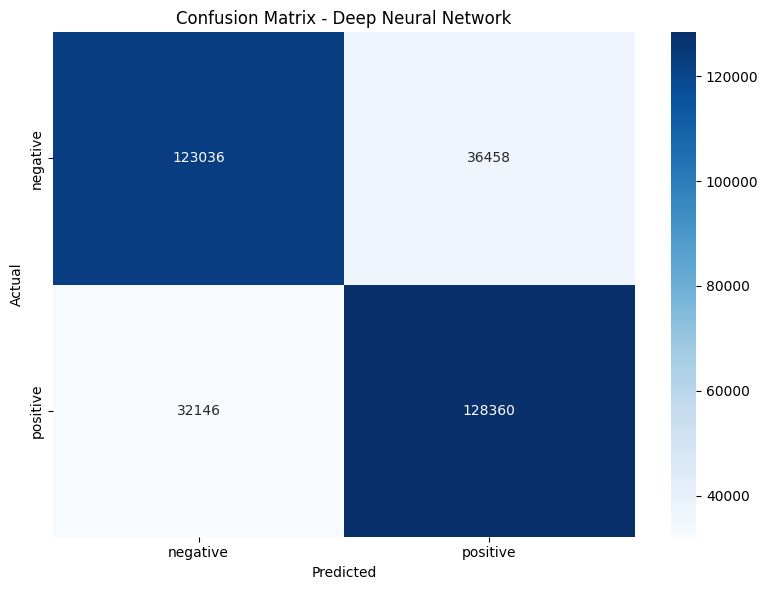

In [16]:
# Get best model index
best_model_idx = np.argmax(accuracies)
best_model = models[best_model_idx]
best_pred = predictions[best_model_idx]

# Plot confusion matrix for best model
plt.figure(figsize=(8, 6))
class_labels = sorted(list(set(y_test)))  # Ensure correct class order
cm = confusion_matrix(y_test, best_pred, labels=class_labels)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cmap='Blues')
plt.title(f'Confusion Matrix - {best_model}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# **A SUMMARY TABLE FOR THE RESULTS**

In [17]:
# Create summary table
results_df = pd.DataFrame({
    'Model': models,
    'Accuracy': [f"{acc:.4f}" for acc in accuracies]
})

# **A SUMMARY FOR ALL THE MODELS USED:**

In [19]:
# Ensure all predictions are available
y_pred_lr = lr.predict(X_test_vec)
y_pred_nb = nb.predict(X_test_vec)
y_pred_rf = rf_fast_pred

# DNN

def sparse_batch_generator(X_sparse, batch_size=64):
    n = X_sparse.shape[0]
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        dense_batch = np.asarray(
            [X_sparse[i].toarray().ravel() for i in range(start, end)],
            dtype=np.float32
        )
        yield dense_batch

def sparse_batch_generator(X_sparse, batch_size=64):
    n = X_sparse.shape[0]
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        dense_batch = np.asarray(
            [X_sparse[i].toarray().ravel() for i in range(start, end)],
            dtype=np.float32
        )
        yield dense_batch

# DNN predictions in memory-safe batches
dnn_probs = []
for xb in sparse_batch_generator(X_test_vec, batch_size=64):
    dnn_probs.append(dnn_model.predict(xb, verbose=0))

dnn_output = np.vstack(dnn_probs)
dnn_pred   = label_encoder.inverse_transform(dnn_output.argmax(axis=1))

# === Classification Reports ===
print("\n=== MODEL PERFORMANCE SUMMARY ===")

print("\n📌 Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

print("\n📌 Naive Bayes:")
print(classification_report(y_test, y_pred_nb))

print("\n📌 Fast Random Forest:")
print(classification_report(y_test, y_pred_rf))

print("\n📌 Deep Neural Network:")
print(classification_report(y_test, dnn_pred))


=== MODEL PERFORMANCE SUMMARY ===

📌 Logistic Regression:
              precision    recall  f1-score   support

    negative       0.79      0.75      0.77    159494
    positive       0.76      0.80      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.78      0.77      0.77    320000
weighted avg       0.78      0.77      0.77    320000


📌 Naive Bayes:
              precision    recall  f1-score   support

    negative       0.75      0.77      0.76    159494
    positive       0.76      0.75      0.76    160506

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000


📌 Fast Random Forest:
              precision    recall  f1-score   support

    negative       0.71      0.48      0.57    159494
    positive       0.61      0.80      0.69    160506

    accuracy                           0.64    320000
   macro avg       0.66      0

Generated confusion matrices and classification reports to analyze the precision, recall, and F1-score of each model. Used seaborn to visually inspect misclassifications.



# **PREDICTION OF THE SENTIMENT FOR A NEW TWEET USING ALL THE TRAINED MODELS**

In [20]:
def predict_sentiment(tweet):
    print(f"\n📝 Input Tweet: {tweet}")

    # Clean same as training
    def clean_text(text):
        text = text.lower()
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
        text = re.sub(r'\@\w+|\#','', text)
        text = re.sub(r'[^a-z\s]', '', text)
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        return ' '.join(tokens)

    cleaned = clean_text(tweet)
    vec = vectorizer.transform([cleaned])

    print("\n🔍 Model Predictions:")

    # Logistic Regression
    print("Logistic Regression:", lr.predict(vec)[0])

    # Naive Bayes
    print("Naive Bayes:", nb.predict(vec)[0])

    # Random Forest
    print("Random Forest:", rf_fast.predict(vec)[0])

    # DNN
    dnn_input = tf.convert_to_tensor(vec.toarray().astype(np.float32))
    dnn_output = dnn_model.predict(dnn_input)
    dnn_pred = label_encoder.inverse_transform([np.argmax(dnn_output)])
    print("DNN:", dnn_pred[0])

    # # BERT
    # bert_tokens = tokenizer(tweet, return_tensors='tf', truncation=True, padding=True)
    # bert_logits = bert_model.predict(bert_tokens).logits
    # bert_pred = tf.argmax(bert_logits, axis=1).numpy()[0]
    # print("BERT:", label_encoder_bert.inverse_transform([bert_pred])[0])

# **RESULTS FOR THREE DIFFERENT SENTENCES**

In [21]:
predict_sentiment("I absolutely love this new phone! It's amazing.🔥")
predict_sentiment("The update ruined everything. I'm so disappointed.")
predict_sentiment("It's okay, not good, not bad.")


📝 Input Tweet: I absolutely love this new phone! It's amazing.🔥

🔍 Model Predictions:
Logistic Regression: positive
Naive Bayes: positive
Random Forest: positive


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.0s finished


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
DNN: positive

📝 Input Tweet: The update ruined everything. I'm so disappointed.

🔍 Model Predictions:
Logistic Regression: negative
Naive Bayes: negative
Random Forest: negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.0s finished


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
DNN: negative

📝 Input Tweet: It's okay, not good, not bad.

🔍 Model Predictions:
Logistic Regression: negative
Naive Bayes: negative
Random Forest: positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.0s finished


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
DNN: positive
